<a href="https://colab.research.google.com/github/vtien/Neural_Network_From_Scratch/blob/main/numpy_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part a

In [ ]:
import torchvision as thv
train = thv.datasets.MNIST('./', download=True, train=True) 
val = thv.datasets.MNIST('./', download=True, train=False)
print(train.data.shape, len(train.targets))

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!
torch.Size([60000, 28, 28]) 60000



/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Split the data into train and test sets. Stratify parameter is used to ensure balancing of classes in the sub-samples

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
targets = train.targets
train_idx, valid_idx= train_test_split(np.arange(len(targets)), train_size=30000, random_state=42, shuffle=True, stratify=targets)

In [ ]:
targets = val.targets
val_idx, valid_idx= train_test_split(np.arange(len(targets)), train_size=5000, random_state=42, shuffle=True, stratify=targets) 
#use train test split but only grab the indices to create a subsample of size 5000

In [ ]:
x_train, y_train = train.data[train_idx], train.targets[train_idx]
x_val, y_val = val.data[val_idx], val.targets[val_idx]

Let's verify that the new training set has roughly 3000 images per class

In [ ]:
from collections import Counter
Counter(y_train.numpy())

Counter({0: 2962,
         1: 3371,
         2: 2979,
         3: 3066,
         4: 2921,
         5: 2710,
         6: 2959,
         7: 3132,
         8: 2925,
         9: 2975})

We can see that this is the case. Next, let's make sure the new validation set has roughly 500 samples per class

In [ ]:
Counter(y_val.numpy())

Counter({0: 490,
         1: 567,
         2: 516,
         3: 505,
         4: 491,
         5: 446,
         6: 479,
         7: 514,
         8: 487,
         9: 505})

Now that this has been verified, let's plot a few images from the training set

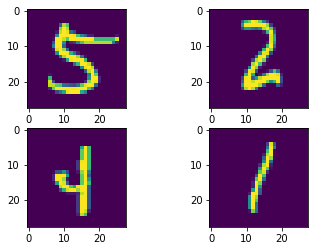

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(x_train[0])
axs[1,0].imshow(x_train[50])
axs[1,1].imshow(x_train[100])
axs[0,1].imshow(x_train[1000])
plt.show()

# Part b

In [ ]:
import numpy.linalg as LA

class linear_t:
  def __init__(self):
    w_init = np.random.randn(10,784) #weights initialized to 10 rows (# of classes) by 784 columns (number of features in each image)
    b_init = np.random.randn(1,10)
    w_norm = LA.norm(w_init, 'fro') #calculate Frobenius norms
    b_norm = LA.norm(b_init, 'fro')
    self.w = np.divide(w_init, w_norm) #normalize
    self.b = np.divide(b_init, b_norm)

  def forward(self, h_l):
    #h_l is the input data (dimensions: batch size x features)
    h_l = h_l.reshape(-1,784)
    h_l_1 = np.dot(h_l, self.w.T) + self.b[:h_l.shape[0], :]
    self.hl = h_l #cache h_l because it will be used to compute the gradient in backward
    return np.array(h_l_1)

  def backward(self, dh_l_1):
    self.dw = np.dot(dh_l_1.T, self.hl) #derivative of cost w.r.t the current layer (dh_l_1) * derivative of layer w.r.t W (self.h1)
    #self.db = np.dot(dh_l_1,1)
    self.db = np.dot(np.ones((1, self.hl.shape[0])), dh_l_1)
    dh1_dh = self.w
    dh_l = np.dot(dh_l_1, dh1_dh) #define gradient of previous layer with respect to the input, which is the gradient from the layer above it
    return dh_l
  
  def zero_grad(self):
    # useful to delete the stored backprop gradients of the
    # previous mini-batch before you start a new mini-batch
    self.dw, self.db = 0*self.dw, 0*self.db

# Part c

In [ ]:
class relu_t:
  #def __init__(self):
    #nothing to initialize

  def forward(self, h1):
    #h1 is the output from linear layer
    relu_h_l_1 = np.maximum(0, h1) #ReLU layer, element-wise maximum array returned
    self.hl = h1 #cache h1 because it will be used to compute the gradient in backward
    return relu_h_l_1

  def backward(self, dh_l_1):
    dh_l = dh_l_1 * (self.hl > 0)
    return dh_l

# Part d

In [ ]:
import math
class softmax_cross_entropy_t:
  #def __init__(self):
    #nothing to initialize

  def forward(self, h_l, y):
    #h_l is a row vector that is the result of the dot product between weight and inputs, with the reLU applied
    self.beta = h_l.shape[0] #number of rows in the mini-batch

    #define hot_y again as the one-hot encoded label (this will happen each iteration of the training loop)
    hot_y = np.zeros((32, 10))
    hot_y[np.arange(np.array(y).size),y] = 1
    self.y_lab = hot_y

    #calculate softmax output
    exp_h_l = np.exp(h_l - np.max(h_l, axis=1).reshape(-1,1))
    denom = np.sum(exp_h_l, axis=1, keepdims=True)
    h_l_1 = exp_h_l / denom #broadcast Nones for division
    self.h_l_plus_1 = h_l_1 #prediction probabilities

    #get indices of y label and extract log of softmax layer from that for each row
    cross_entropy_loss = h_l_1[np.arange(h_l_1.shape[0]), y] #essentially multiplying row of hot_y by row of pred probabilities h^(l+1)
    cross_entropy_loss = -np.log(cross_entropy_loss)

    #calculate error
    wrong = 0
    for b in range(self.beta):
      true = np.argmax(hot_y[b])
      prediction = np.argmax(h_l_1[b,:])
      if true != prediction:
        wrong+=1
    
    ell =  np.sum(cross_entropy_loss) * 1/self.beta #average loss over the mini-batch
    error = 1/self.beta * wrong
    return ell, error

  def backward(self):
    dh_l = (self.h_l_plus_1 - self.y_lab) / self.beta # multiplied by 1
    return dh_l

# Part e

In [ ]:
sample_img = train.data[0].numpy()

In [ ]:
#convert data to numpy
x_train, x_val, y_train, y_val = x_train.numpy(), x_val.numpy(), y_train.numpy(), y_val.numpy()

Here I implement a backward_check function to the linear_t class to use the method of finite differences as verification of my gradients

In [ ]:
import random
class linear_t:
  def __init__(self):
    w_init = np.random.randn(10,784) #weights initialized to 10 rows (# of classes) by 784 columns (number of features in each image)
    b_init = np.random.randn(1,10)
    w_norm = LA.norm(w_init, 'fro') #calculate Frobenius norms
    b_norm = LA.norm(b_init, 'fro')
    self.w = np.divide(w_init, w_norm) #normalize
    self.b = np.divide(b_init, b_norm)

  def forward(self, h_l):
    #h_l is the input data (dimensions: batch size x features)
    h_l = h_l.reshape(-1,784)
    h_l_1 = np.dot(h_l, self.w.T) + self.b
    self.hl = h_l #cache h_l because it will be used to compute the gradient in backward
    return np.array(h_l_1)

  def backward(self, dh_l_1):
    self.dw = np.dot(dh_l_1.T, self.hl) #derivative of cost w.r.t the current layer (dh_l_1) * derivative of layer w.r.t W (self.h1)
    self.db = np.dot(dh_l_1.T, np.ones((self.hl.shape[0], 1)))
    dh1_dh = self.w
    dh_l = np.dot(dh_l_1, dh1_dh) #define gradient of previous layer with respect to the input, which is the gradient from the layer above it
    return dh_l

  def backward_check(self):
    #compute finite differences and compare values with backward function
    #construct epsilon
    epsilon = np.zeros((10,784))
    epsilon_change = 0.034   #np.random.normal()
    #i, j = random.sample(range(0,10), 1), random.sample(range(0,784), 1)
    epsilon[0,161] = epsilon_change

    ## dw check
    first = np.dot(self.hl,(self.w + epsilon).T)
    second = np.dot(self.hl,(self.w - epsilon).T)
    self.dw_check = (first-second)/(2*0.034)

    ## db check
    epsilon = np.zeros((1,10))
    epsilon[0,4] = epsilon_change
    b_first = np.dot(np.ones((self.hl.shape[0], 1)),(self.b + epsilon))
    b_second = np.dot(np.ones((self.hl.shape[0], 1)),(self.b - epsilon))
    self.db_check = (b_first-b_second)/(2*0.034)

    ## dh_l check
    epsilon = np.zeros((1,784))
    epsilon[0,4] = epsilon_change
    h_first = np.dot(self.w,(self.hl+ epsilon).T)
    h_second = np.dot(self.w,(self.hl - epsilon).T)
    self.dh_l_check = (h_first-h_second)/(2*0.034)
  
  def zero_grad(self):
    # useful to delete the stored backprop gradients of the
    # previous mini-batch before you start a new mini-batch
    self.dw, self.db = 0*self.dw, 0*self.db

In [ ]:
l1 = linear_t()

In [ ]:
l1.forward(sample_img).shape

(1, 10)

Create a sample dh that is all zeros except for a 1 at the kth location

In [ ]:
#k = 5
sample_dh_l_1 = np.zeros((1,10))
sample_dh_l_1[0,5] = 1

In [ ]:
output = l1.backward(sample_dh_l_1)

In [ ]:
l1.backward_check()

Check dw

In [ ]:
l1.dw[0,161]

0.0

In [ ]:
l1.dw_check
#correct because kth (5) element is 0

array([[255.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

Check db

In [ ]:
l1.db_check[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [ ]:
l1.db

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.]])

Check dh

In [ ]:
#0, 5 in the estimator should match up with 0,4 in the actual dh_l that is output
l1.dh_l_check

array([[ 0.00451776],
       [ 0.02226187],
       [-0.0043443 ],
       [-0.00359538],
       [ 0.01236908],
       [-0.00545147],
       [ 0.00276677],
       [ 0.00572642],
       [-0.00235777],
       [-0.01213609]])

In [ ]:
output[0,4]

-0.005451473396844402

These all look good, so next I move on to training the network

# Part f

In [ ]:
#convert data to numpy
#x_train, x_val, y_train, y_val = x_train.numpy(), x_val.numpy(), y_train.numpy(), y_val.numpy()
x_train, x_val = x_train/255, x_val/255

In [ ]:
import random
import numpy as np

#initialize all layers
l1, l2, l3 = linear_t(), relu_t(), softmax_cross_entropy_t()
net = [l1, l2, l3]

#set learning rate
lr = 0.1

# train for at least 1000 iterations
error_vals = []
loss = []
for t in range(10000):
  # 1. sample a mini-batch of size = 32
  # each image in the mini-batch is chosen uniformly randomly from the
  # training dataset
  idx = random.sample(range(0, 30000), 32) #create random indices to sample data
  x, y = x_train[idx,:,:], y_train[idx]
  

  # 2. forward pass
  h1 = l1.forward(x)
  h2 = l2.forward(h1)
  print(h2.shape)
  break
  ell, error = l3.forward(h2, y)

  
  # # 3. backward pass
  dh2 = l3.backward()
  dh1 = l2.backward(dh2)
  dx = l1.backward(dh1)
  
  # 4. gather backprop gradients
  dw, db = l1.dw, l1.db
  
  # 5. print some quantities for logging
  # and debugging
  print(t, ell, error)
  #print(t, np.linalg.norm(dw/l1.w), np.linalg.norm(db/l1.b))
  error_vals.append(error)
  loss.append(ell)
  
  # 6. one step of SGD
  l1.w = l1.w - lr*dw
  l1.b = l1.b - lr*db

  # 7. zero gradient buffer
  l1.zero_grad()

(32, 10)


In [ ]:
import random
import numpy as np

#initialize all layers
l1, l2, l3 = linear_t(), relu_t(), softmax_cross_entropy_t()
net = [l1, l2, l3]

#set learning rate
lr = 0.1

# train for at least 1000 iterations
error_vals = []
loss = []
for t in range(10000):
  # 1. sample a mini-batch of size = 32
  # each image in the mini-batch is chosen uniformly randomly from the
  # training dataset
  idx = random.sample(range(0, 30000), 32) #create random indices to sample data
  x, y = x_train[idx,:,:], y_train[idx]
  

  # 2. forward pass
  h1 = l1.forward(x)
  h2 = l2.forward(h1)
  ell, error = l3.forward(h2, y)

  
  # # 3. backward pass
  dh2 = l3.backward()
  dh1 = l2.backward(dh2)
  dx = l1.backward(dh1)
  
  # 4. gather backprop gradients
  dw, db = l1.dw, l1.db
  
  # 5. print some quantities for logging
  # and debugging
  print(t, ell, error)
  #print(t, np.linalg.norm(dw/l1.w), np.linalg.norm(db/l1.b))
  error_vals.append(error)
  loss.append(ell)
  
  # 6. one step of SGD
  l1.w = l1.w - lr*dw
  l1.b = l1.b - lr*db

  # 7. zero gradient buffer
  l1.zero_grad()

Streaming output truncated to the last 5000 lines.
5001 0.5003310960414252 0.1875
5002 0.4526973494575426 0.15625
5003 0.4537260747982548 0.15625
5004 0.6215589853526369 0.21875
5005 0.5811849462483659 0.15625
5006 0.6901938987924987 0.28125
5007 0.315102064646561 0.125
5008 0.5105165441418131 0.21875
5009 0.5373181564789726 0.15625
5010 0.8760733986332381 0.28125
5011 0.38209844847634533 0.15625
5012 0.359094972486132 0.09375
5013 0.5806473662160596 0.21875
5014 0.4527687615449938 0.15625
5015 0.45736949142763517 0.1875
5016 0.6983673419212342 0.25
5017 0.5829832321865631 0.25
5018 0.8436726900013376 0.3125
5019 0.3217134948508535 0.125
5020 0.673037245441632 0.21875
5021 0.40122234275398505 0.125
5022 0.7441162288432853 0.3125
5023 0.6135597798972607 0.1875
5024 0.7044679670994939 0.21875
5025 0.8391109973522274 0.34375
5026 0.6446712879641548 0.25
5027 0.46837312019682187 0.21875
5028 0.7470276242816789 0.28125
5029 0.3640476354973392 0.09375
5030 0.43826809048714144 0.21875
5031 0.

Plot (include all plots in pdf)

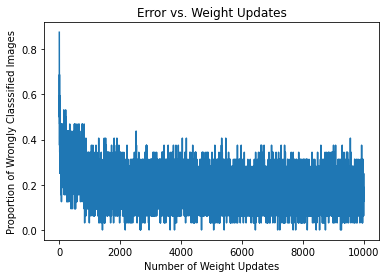

In [ ]:
import matplotlib.pyplot as plt
plt.plot(error_vals)
plt.title('Error vs. Weight Updates')
plt.xlabel('Number of Weight Updates')
plt.ylabel('Proportion of Wrongly Classsified Images')
plt.show()

Smoother version of same plot

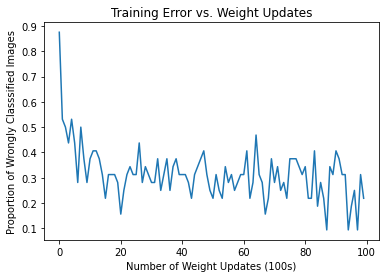

In [ ]:
import matplotlib.pyplot as plt
plt.plot(error_vals[0::100])
plt.title('Training Error vs. Weight Updates')
plt.xlabel('Number of Weight Updates (100s)')
plt.ylabel('Proportion of Wrongly Classsified Images')
plt.show()

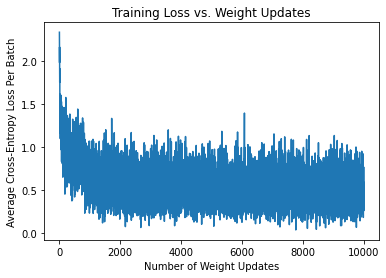

In [ ]:
plt.plot(loss)
plt.title('Training Loss vs. Weight Updates')
plt.xlabel('Number of Weight Updates')
plt.ylabel('Average Cross-Entropy Loss Per Batch')
plt.show()

Smoother version of same plot

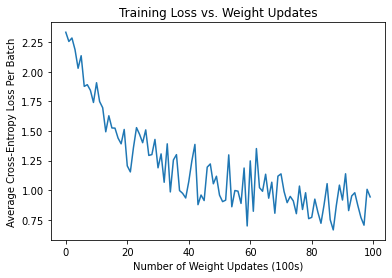

In [ ]:
plt.plot(loss[0:100])
plt.title('Training Loss vs. Weight Updates')
plt.xlabel('Number of Weight Updates (100s)')
plt.ylabel('Average Cross-Entropy Loss Per Batch')
plt.show()

# Part g

In [ ]:
def validate(train_w, train_b):
  # 1. iterate over mini-batches from the validation dataset
  # note that this should not be done randomly, we want to check
  # every image only once
  loss, tot_error = 0, 0
  tot=0
  l1 = linear_t()
  l1.w = train_w
  l1.b = train_b
  for i in range(0, 5000, 32):
    x, y = x_val[i:i+32], y_val[i:i+32]
    
    # 2. compute forward pass and error
    h1 = l1.forward(x)
    h2 = l2.forward(h1)
    ell, error = l3.forward(h2, y)
    loss+=ell
    tot_error+=error
    tot+=1

  loss, tot_error = loss/tot, tot_error/tot
  return loss, tot_error

Train network again while recording validation loss/error

In [ ]:
#initialize all layers
l1, l2, l3 = linear_t(), relu_t(), softmax_cross_entropy_t()
net = [l1, l2, l3]

#set learning rate
lr = 0.1

# train for at least 1000 iterations
error_vals = []
val_error_list = []
loss = []
val_loss_list = []
j=0
for t in range(10000):
  # 1. sample a mini-batch of size = 32
  # each image in the mini-batch is chosen uniformly randomly from the
  # training dataset
  idx = random.sample(range(0, 30000), 32) #create random indices to sample data
  x, y = x_train[idx,:,:], y_train[idx]
  

  # 2. forward pass
  h1 = l1.forward(x)
  h2 = l2.forward(h1)
  ell, error = l3.forward(h2, y)

  
  # # 3. backward pass
  dh2 = l3.backward()
  dh1 = l2.backward(dh2)
  dx = l1.backward(dh1)
  
  # 4. gather backprop gradients
  dw, db = l1.dw, l1.db
  
  # 5. print some quantities for logging
  # and debugging
  print(t, ell, error)
  #print(t, np.linalg.norm(dw/l1.w), np.linalg.norm(db/l1.b))
  error_vals.append(error)
  loss.append(ell)
  
  # 6. one step of SGD
  l1.w = l1.w - lr*dw
  l1.b = l1.b - lr*db

  # 7. calculate validation loss and error
  train_w, train_b = l1.w, l1.b
  val_loss, val_error = validate(train_w, train_b)
  val_error_list.append(val_error)
  val_loss_list.append(val_loss)

  # 8. zero gradient buffer
  l1.zero_grad()

Streaming output truncated to the last 5000 lines.
5001 0.6276976956436929 0.1875
5002 0.7655773952711867 0.3125
5003 1.1555756092036975 0.40625
5004 0.81026991883363 0.3125
5005 1.0013316501583382 0.375
5006 1.1287373576656003 0.375
5007 0.8599946164331358 0.3125
5008 0.8328386910920911 0.28125
5009 1.2578389952574052 0.46875
5010 0.4742459515306688 0.1875
5011 1.0323667316806973 0.40625
5012 0.8103715724416642 0.28125
5013 1.0475798588230816 0.375
5014 1.038235859965452 0.34375
5015 1.1192871334313454 0.4375
5016 1.0413461428104065 0.40625
5017 1.2915797700753462 0.46875
5018 1.1558763216981571 0.4375
5019 0.9418885306090297 0.34375
5020 0.7006163252395373 0.25
5021 0.6949639991579466 0.15625
5022 0.7918090402324545 0.3125
5023 0.7003151822507626 0.21875
5024 0.5148296659712892 0.1875
5025 1.1682106718860306 0.40625
5026 1.1657763180915544 0.375
5027 1.2045771109571373 0.40625
5028 1.159748800737979 0.46875
5029 0.9038449443629966 0.3125
5030 0.9208796997625497 0.3125
5031 1.13856431

Create plots

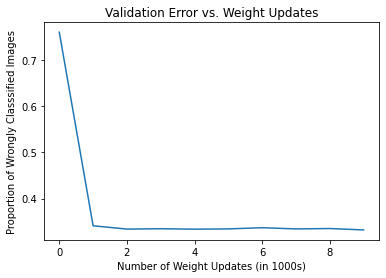

In [ ]:
import matplotlib.pyplot as plt
plt.plot(val_error_list[0::1000]) #grab every 1000th element
plt.title('Validation Error vs. Weight Updates')
plt.xlabel('Number of Weight Updates (in 1000s)')
plt.ylabel('Proportion of Wrongly Classsified Images')
plt.show()

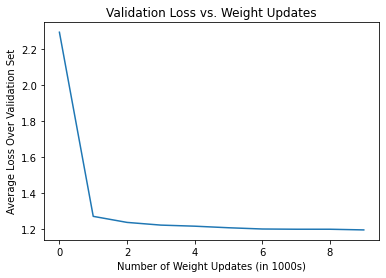

In [ ]:
plt.plot(val_loss_list[0::1000])
plt.title('Validation Loss vs. Weight Updates')
plt.xlabel('Number of Weight Updates (in 1000s)')
plt.ylabel('Average Loss Over Validation Set')
plt.show()

# Part h

In [ ]:
import torch

Convert back to tensors

In [ ]:
x_train, x_val, y_train, y_val = torch.from_numpy(x_train) , torch.from_numpy(x_val), torch.from_numpy(y_train), torch.from_numpy(y_val)

Create dataloader objects from sub-sampled data

In [ ]:
from torch.utils.data import TensorDataset
train = TensorDataset(x_train, y_train)
val = TensorDataset(x_val, y_val)

In [ ]:
trainset = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
valset = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True)

Create network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 10) #simple one-layer network, as was constructed from scratch above
  
  def forward(self, x):
    x = F.relu(self.fc1(x))
    return F.log_softmax(x, dim=1)

In [ ]:
import torch.optim as optim

net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.1)
error = 0
total = 0
epochs = 13
loss_list = []
train_error_list = []
val_loss_list = []
val_error_list = []
for e in range(epochs):
  for data in trainset:
    x_train, y_train = data #one batch of data
    net.zero_grad()
    output = net(x_train.view(-1,784).float()) #forward pass

    #calculate training error
    for idx, pred in enumerate(output):
      if torch.argmax(pred) != y_train[idx]:
        error+=1
      total+=1

    #calculate validation error average over whole validation set
    v_total = 0
    v_error = 0
    v_loss = 0
    for v_data in valset:
      x_val, y_val = v_data
      val_output = net(x_val.view(-1,784).float())
      for v_idx, val_pred in enumerate(val_output):
        if torch.argmax(val_pred) != y_val[v_idx]:
          v_error+=1
        v_total+=1

      validation_loss = F.nll_loss(val_output, y_val)
      v_loss += validation_loss.item()

    val_loss_list.append(v_loss/v_total)
    val_error_list.append(v_error/v_total)

    #backpropagate loss
    loss = F.nll_loss(output, y_train)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    train_error_list.append(round(error/total, 3))

Plot training metrics

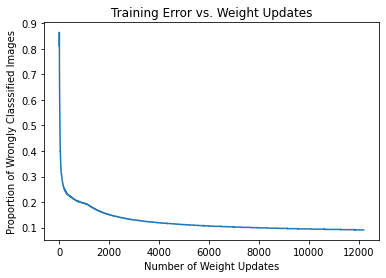

In [ ]:
plt.plot(train_error_list)
plt.title('Training Error vs. Weight Updates')
plt.xlabel('Number of Weight Updates')
plt.ylabel('Proportion of Wrongly Classsified Images')
plt.show()

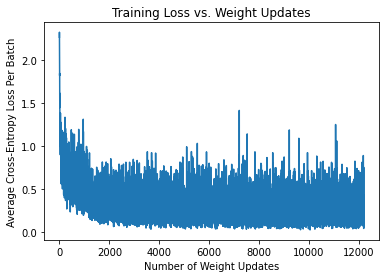

In [ ]:
plt.plot(loss_list)
plt.title('Training Loss vs. Weight Updates')
plt.xlabel('Number of Weight Updates')
plt.ylabel('Average Cross-Entropy Loss Per Batch')
plt.show()

Plot validation metrics

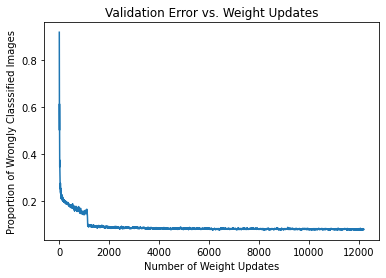

In [ ]:
plt.plot(val_error_list)
plt.title('Validation Error vs. Weight Updates')
plt.xlabel('Number of Weight Updates')
plt.ylabel('Proportion of Wrongly Classsified Images')
plt.show()

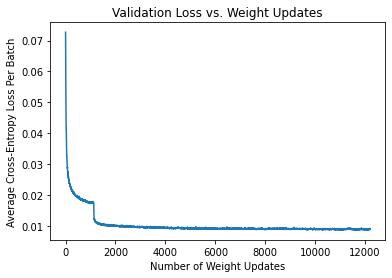

In [ ]:
plt.plot(val_loss_list)
plt.title('Validation Loss vs. Weight Updates')
plt.xlabel('Number of Weight Updates')
plt.ylabel('Average Cross-Entropy Loss Per Batch')
plt.show()